In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
from tqdm.auto import tqdm
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights



D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, is_train=True, fraction=1.0):
        """
        Initializes the SegmentationDataset.

        Parameters:
            images_dir (str): Path to the directory containing the images.
            masks_dir (str): Path to the directory containing the masks.
            is_train (bool): If True, apply data augmentation; if False, only basic preprocessing.
            fraction (float): The fraction of the dataset to use. Default is 1.0 (use the entire dataset).
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = os.listdir(images_dir)
      
        # Apply fraction if less than 1
        if 0 < fraction < 1:
            subset_size = int(len(self.images) * fraction)
            self.images = random.sample(self.images, subset_size)
        
        # Set up transforms
        self.transform, self.mask_transform = self.get_transforms(is_train)

    def get_transforms(self, is_train):
        """
        Get the transform and mask transform based on whether data augmentation is needed.

        Parameters:
            is_train (bool): Whether to apply data augmentation.

        Returns:
            (tuple): A tuple containing the image and mask transforms.
        """
        #训练集做数据增强
        if is_train:
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                # transforms.RandomHorizontalFlip(p=0.5),
                # transforms.RandomVerticalFlip(p=0.5),
                # transforms.RandomRotation(degrees=15),
                # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                # transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
                transforms.ToTensor(),
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])

        # Mask transform with nearest-neighbor interpolation
        mask_transform = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST),
            transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long)),
        ])

        return transform, mask_transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        
        # Extract file extension to find corresponding mask
        image_extension = os.path.splitext(self.images[idx])[1]
        mask_name = os.path.join(self.masks_dir, self.images[idx].replace(image_extension, '.png'))
        mask = Image.open(mask_name).convert("L")

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask.squeeze(0)

In [3]:
# Load and split datasets


train_path = 'deeplabv3/train'
val_path = 'deeplabv3/val/'
test_path = 'deeplabv3/test/'

train_mask_path = 'deeplabv3/masks/train'
val_mask_path = 'deeplabv3/masks/val/'
test_mask_path = 'deeplabv3/masks/test/'


# 加载数据集
# 划分数据集为训练集和测试集
train_dataset = SegmentationDataset(train_path, train_mask_path,is_train=True, fraction=0.6)
val_dataset = SegmentationDataset(val_path, val_mask_path, is_train=False, fraction=0.6)
test_dataset = SegmentationDataset(test_path, test_mask_path, is_train=False, fraction=0.6)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)  # Batch size increased
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,  pin_memory=True)

# Load and modify DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 4  # 0 background 1 carapace 2 flipper 3 head
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Improved class weights to better handle class imbalance
weights = torch.tensor([0.2, 1.0, 2.0, 2.0], dtype=torch.float32).to(device)  # Adjusted class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Use AdamW optimizer for better regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler for dynamic adjustment
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)



cuda


In [4]:
def calculate_metrics(predictions, masks, num_classes):
    metrics = {
        'iou': np.zeros(num_classes),
        'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
    }

    # Calculate IoU per class
    for cls in range(num_classes):
        pred_mask = (predictions == cls).astype(np.uint8)
        true_mask = (masks == cls).astype(np.uint8)
        
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        
        if union > 0:
            metrics['iou'][cls] = intersection / union  # IoU for each class

    metrics['confusion_matrix'] = confusion_matrix(masks.flatten(), predictions.flatten(), labels=range(num_classes))
    return metrics


def model_eval(model, val_loader, num_classes, output_path='out'):
    model.eval()
    os.makedirs(output_path, exist_ok=True)
    
    # Initialize arrays to store cumulative metrics across all images in the validation set
    all_metrics = {
        'iou': [],
        'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
    }

    # Evaluate model without computing gradients
    with torch.no_grad():
        for images, masks in val_loader:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass to get predictions
            outputs = model(images)['out']
            predictions = outputs.argmax(dim=1).cpu().numpy()
            true_masks = masks.cpu().numpy()

            # Calculate metrics for each image in the batch
            for pred, true_mask in zip(predictions, true_masks):
                metrics = calculate_metrics(pred, true_mask, num_classes)
                all_metrics['iou'].append(metrics['iou'])
                all_metrics['confusion_matrix'] += metrics['confusion_matrix']

    # Calculate IoU for each class and the mean IoU
    iou_array = np.vstack(all_metrics['iou'])
    mean_iou_per_class = np.nanmean(iou_array[:, 1:], axis=0)
    overall_mean_iou = np.nanmean(mean_iou_per_class)
    confusion_matrix_total = all_metrics['confusion_matrix']

    # Plot IoU per Class and Overall Mean IoU (excluding background)
    class_labels = ["Carapace", "Flippers", "Head"]
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels + ["Mean IoU"], np.append(mean_iou_per_class, overall_mean_iou), color='lightblue')
    plt.ylim(0, 1)
    plt.ylabel("IoU")
    plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")
    for i, v in enumerate(np.append(mean_iou_per_class, overall_mean_iou)):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    plt.savefig(os.path.join(output_path, "iou_per_class.png"))
    plt.close()

    # Normalize the confusion matrix
    normalized_confusion_matrix = confusion_matrix_total.astype('float') / confusion_matrix_total.sum(axis=1, keepdims=True)

    # Plot normalized confusion matrix
    all_class_labels = ["Background", "Carapace", "Flippers", "Head"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=all_class_labels, yticklabels=all_class_labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Normalized Confusion Matrix")
    plt.savefig(os.path.join(output_path, "normalized_confusion_matrix.png"))
    plt.close()


    

In [9]:
num_epochs = 5
train_losses = []
learning_rates = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as progress_bar:
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks.long())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training loss
            epoch_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

            # Get the current learning rate
            current_lr = optimizer.param_groups[0]['lr']

            # Update progress bar with current loss and accuracy
            progress_bar.set_postfix({
                'Loss': loss.item(),
                'Accuracy': 100.0 * correct / total,
                'LR': current_lr
            })

    # Append epoch loss and learning rate
    train_losses.append(epoch_loss / len(train_loader))
    learning_rates.append(current_lr)

    # Scheduler step
    scheduler.step()

    # Print epoch summary
    epoch_accuracy = 100.0 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Loss: {epoch_loss / len(train_loader):.4f} | "
          f"Accuracy: {epoch_accuracy:.2f}% | "
          f"Learning Rate: {current_lr:.6f}")

# Save the model
torch.save(model.state_dict(), f'dp_ep{num_epochs}.pth')
print("Training complete.")

Epoch [1/5]:  11%|█         | 44/398 [02:55<23:32,  3.99s/it, Loss=0.946, Accuracy=72.6, LR=0.0001]


KeyboardInterrupt: 

In [5]:
#载入训练好的模型
model = torchvision.models.segmentation.__dict__["deeplabv3_resnet101"](aux_loss=False, num_classes=4)
checkpoint = torch.load('dv3_ep30.pth', map_location="cpu", weights_only=True)
model.load_state_dict({k: v for k, v in checkpoint.items() if 'aux_classifier' not in k}, strict=False)
model = model.to("cuda")  # Moves the model to the GPU

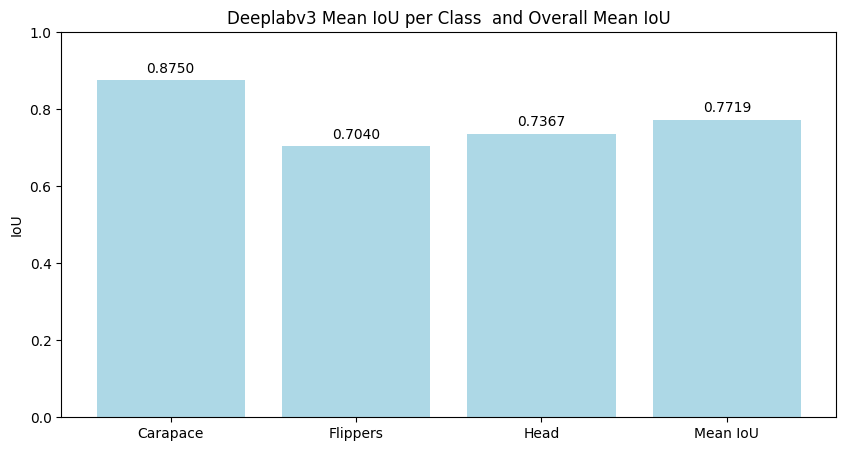

In [7]:
model.eval()
output_path = 'out'
os.makedirs(output_path, exist_ok=True)

# Initialize arrays to store cumulative metrics across all images in the validation set
all_metrics = {
    'iou': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
}

# Evaluate model without computing gradients
with torch.no_grad():
    for images, masks in val_loader:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Move images and masks to device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass to get predictions
        outputs = model(images)['out']
        predictions = outputs.argmax(dim=1).cpu().numpy()
        true_masks = masks.cpu().numpy()

        # Calculate metrics for each image in the batch
        for pred, true_mask in zip(predictions, true_masks):
            metrics = calculate_metrics(pred, true_mask, num_classes)
            all_metrics['iou'].append(metrics['iou'])
            all_metrics['confusion_matrix'] += metrics['confusion_matrix']

# Calculate IoU for each class and the mean IoU
iou_array = np.vstack(all_metrics['iou'])
mean_iou_per_class = np.nanmean(iou_array[:, 1:], axis=0)
overall_mean_iou = np.nanmean(mean_iou_per_class)
confusion_matrix_total = all_metrics['confusion_matrix']
# Plot IoU per Class and Overall Mean IoU (excluding background)
class_labels = ["Carapace", "Flippers", "Head"]
plt.figure(figsize=(10, 5))
plt.bar(class_labels + ["Mean IoU"], np.append(mean_iou_per_class, overall_mean_iou), color='lightblue')
plt.ylim(0, 1)
plt.ylabel("IoU")
plt.title("Deeplabv3 Mean IoU per Class  and Overall Mean IoU")
for i, v in enumerate(np.append(mean_iou_per_class, overall_mean_iou)):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.savefig(os.path.join(output_path, "iou_per_class.png"))
plt.show()
plt.close()


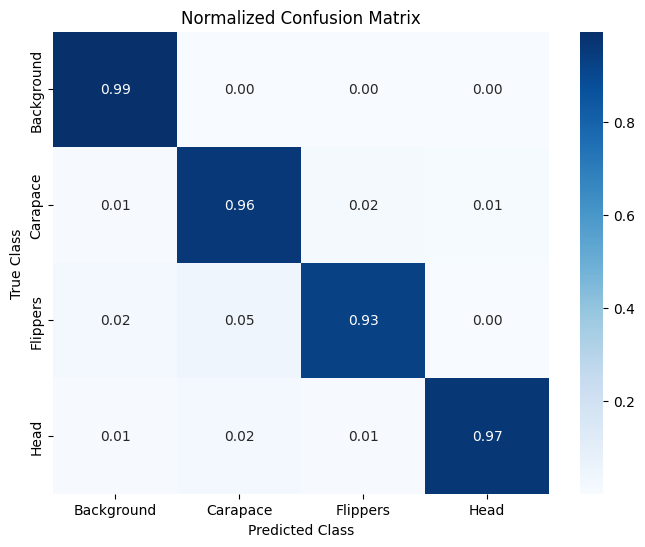

In [8]:
# Normalize the confusion matrix
normalized_confusion_matrix = confusion_matrix_total.astype('float') / confusion_matrix_total.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
all_class_labels = ["Background", "Carapace", "Flippers", "Head"]
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=all_class_labels, yticklabels=all_class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.savefig(os.path.join(output_path, "normalized_confusion_matrix.png"))
plt.show()
plt.close()

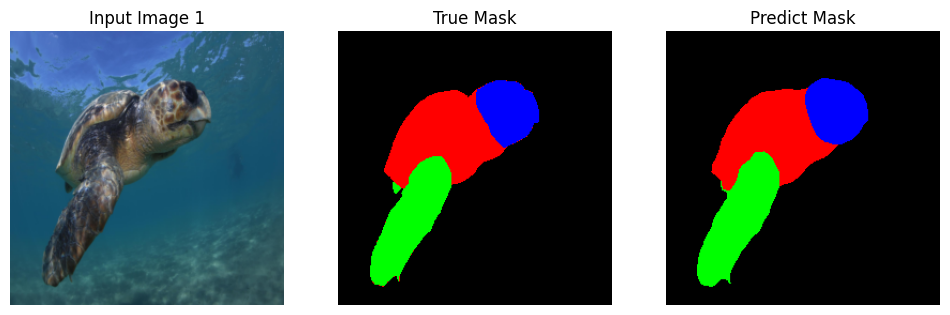

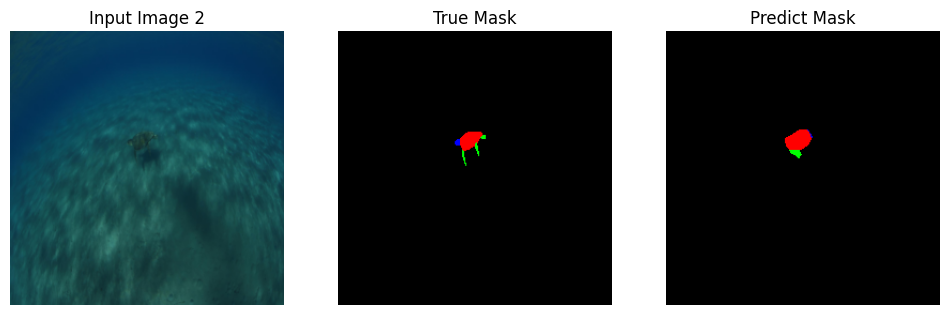

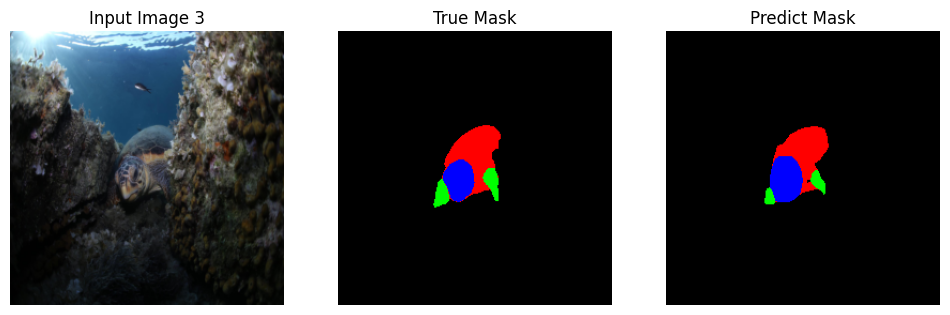

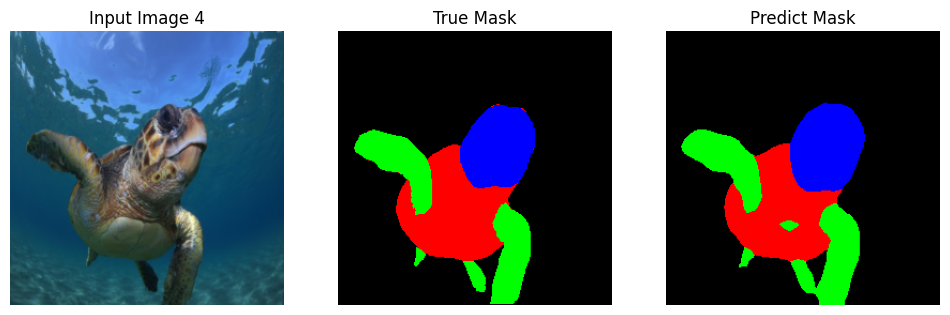

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
colors = {
    0: (0, 0, 0),       # 背景，黑色
    1: (255, 0, 0),     # 类别1，红色
    2: (0, 255, 0),     # 类别2，绿色
    3: (0, 0, 255),     # 类别3，蓝色
}
k= 4
k_images = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        outputs = model(images)['out']
        predictions = outputs.argmax(dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        # Calculate IoU for each image in the batch
        for i in range(images.size(0)):
            k_images.append((images[i].cpu(), masks[i], predictions[i]))

def mask_to_color(mask):
    """
    将掩码转换为彩色图像，按照类别优先级处理。
    优先级：3 > 2 > 1
    """
    # 创建彩色图像
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # 按优先级顺序处理类别
    for class_id in sorted(colors.keys(), reverse=True):  # 从高优先级开始
        color = colors[class_id]
        color_mask[mask == class_id] = color

    return color_mask
    
k_images = k_images[1:k+1]
# Visualize the k images
for idx, (image, mask, prediction) in enumerate(k_images, 1):
    plt.figure(figsize=(12, 6))
    
    # 原始输入图像
    plt.subplot(1, 3, 1)
    plt.title(f"Input Image {idx}")
    plt.imshow(image.permute(1, 2, 0))  # Convert to HWC format
    plt.axis('off')

    # 真实掩码
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    true_mask_color = mask_to_color(mask)
    plt.imshow(true_mask_color)
    plt.axis('off')

    # 预测掩码
    plt.subplot(1, 3, 3)
    plt.title("Predict Mask")
    pred_mask_color = mask_to_color(prediction)
    plt.imshow(pred_mask_color)
    plt.axis('off')

    # 保存和显示
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)
    plt.savefig(os.path.join(output_path, f"image_{idx}.png"))
    plt.show()